In [1]:
!pip install evaluate datasets accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 990.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00


In [1]:
import evaluate
import numpy as np
import pandas as pd

from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, AutoModelForSequenceClassification, Trainer

In [2]:
# datasets = load_dataset("text", data_dir="../data/stack_overflow_16k/")

# split_labels = np.concatenate([np.zeros(2000), np.ones(2000), np.full(2000, 2), np.full(2000, 3)]).astype(int)

# for split, dataset in datasets.items():
#     datasets[split] = dataset.add_column(name="label", column=split_labels)

datasets = load_dataset("csv", data_files={
    "train": "../data/stack_overflow_16k/train/train.csv",
    "test": "../data/stack_overflow_16k/test/test.csv"})
datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 8000
    })
})

In [3]:
datasets["train"][1]

{'text': 'blank bins every 20 minutes i have a time field that goes from 07:00 to 21:00. i want to make bins of 20 minutes, is there something like this in blank:..07:00 - 07:20.07:20 - 07:40.07:40 - 08:00.08:00 - 08:20.08:20 - 08:40.08:40 - 09:00.09:00 - 09:20.09:20 - 09:40.09:40 - 10:00',
 'label': 0}

In [4]:
type(datasets["test"])

datasets.arrow_dataset.Dataset

In [5]:
val_test_splits = datasets["test"].train_test_split(test_size=0.5, shuffle=True, seed=42)
val_test_splits

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 4000
    })
})

In [6]:
datasets["validation"] = val_test_splits["train"]
datasets["test"] = val_test_splits["test"]
datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 4000
    })
})

## Training

In [24]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [25]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_datasets = datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4000
    })
})

A _collate_ function will apply the correct amount of padding to the items of the dataset we want to batch together. Without dynamic padding, all of the samples would have to be padded to the maximum length in the whole dataset, or the maximum length the model can accept.

It takes a tokenizer when instantiated to know which padding token to use, and whether the model expects padding to be on the left or on the right of the inputs.

In [10]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [11]:
training_args = TrainingArguments(
    output_dir="stackoverflow-classifier-training-dir",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
)

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=4)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is due to the fact that BERT has not been pretrained on classifying pairs of sentences, so the head of the pretrained model has been discarded and a new head suitable for sequence classification has been added instead.

In [13]:
def compute_metrics(eval_preds):
    accuracy_metric, precision_metric, recall_metric =\
        evaluate.load("accuracy"), evaluate.load("precision"), evaluate.load("recall")

    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    metrics = accuracy_metric.compute(predictions=predictions, references=labels)
    metrics.update(precision_metric.compute(predictions=predictions, references=labels, average="macro"))
    metrics.update(recall_metric.compute(predictions=predictions, references=labels, average="macro"))

    return metrics

In [14]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

This will start the fine-tuning.

In [15]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.639400,0.392678,0.849750,0.853669,0.849603
2,0.283100,0.319985,0.884000,0.887043,0.883667
3,0.144200,0.379090,0.900000,0.902269,0.899587
4,0.059200,0.470846,0.897750,0.899118,0.897425


TrainOutput(global_step=2000, training_loss=0.2814871892929077, metrics={'train_runtime': 3636.7795, 'train_samples_per_second': 8.799, 'train_steps_per_second': 0.55, 'total_flos': 8376331971196800.0, 'train_loss': 0.2814871892929077, 'epoch': 4.0})

## Evaluation

In [7]:
import seaborn as sns

from transformers import pipeline
from sklearn.metrics import confusion_matrix

### Last model

In [8]:
model_ckpt_last = pipeline(
    "text-classification",
    model="../stackoverflow-classifier-training-dir/checkpoint-2000",
    truncation=True,
    device=-1)

In [27]:
!zip -r stackoverflow-classifier-training-dir/checkpoint-2000.zip stackoverflow-classifier-training-dir/checkpoint-2000

  adding: stackoverflow-classifier-training-dir/checkpoint-2000/ (stored 0%)
  adding: stackoverflow-classifier-training-dir/checkpoint-2000/special_tokens_map.json (deflated 42%)
  adding: stackoverflow-classifier-training-dir/checkpoint-2000/model.safetensors (deflated 7%)
  adding: stackoverflow-classifier-training-dir/checkpoint-2000/config.json (deflated 52%)
  adding: stackoverflow-classifier-training-dir/checkpoint-2000/scheduler.pt (deflated 56%)
  adding: stackoverflow-classifier-training-dir/checkpoint-2000/trainer_state.json (deflated 72%)
  adding: stackoverflow-classifier-training-dir/checkpoint-2000/optimizer.pt (deflated 19%)
  adding: stackoverflow-classifier-training-dir/checkpoint-2000/tokenizer_config.json (deflated 76%)
  adding: stackoverflow-classifier-training-dir/checkpoint-2000/rng_state.pth (deflated 25%)
  adding: stackoverflow-classifier-training-dir/checkpoint-2000/tokenizer.json (deflated 71%)
  adding: stackoverflow-classifier-training-dir/checkpoint-2000

In [28]:
!zip -r stackoverflow-classifier-training-dir/checkpoint-1000.zip stackoverflow-classifier-training-dir/checkpoint-1000

  adding: stackoverflow-classifier-training-dir/checkpoint-1000/ (stored 0%)
  adding: stackoverflow-classifier-training-dir/checkpoint-1000/special_tokens_map.json (deflated 42%)
  adding: stackoverflow-classifier-training-dir/checkpoint-1000/model.safetensors (deflated 7%)
  adding: stackoverflow-classifier-training-dir/checkpoint-1000/config.json (deflated 52%)
  adding: stackoverflow-classifier-training-dir/checkpoint-1000/scheduler.pt (deflated 56%)
  adding: stackoverflow-classifier-training-dir/checkpoint-1000/trainer_state.json (deflated 64%)
  adding: stackoverflow-classifier-training-dir/checkpoint-1000/optimizer.pt (deflated 19%)
  adding: stackoverflow-classifier-training-dir/checkpoint-1000/tokenizer_config.json (deflated 76%)
  adding: stackoverflow-classifier-training-dir/checkpoint-1000/rng_state.pth (deflated 25%)
  adding: stackoverflow-classifier-training-dir/checkpoint-1000/tokenizer.json (deflated 71%)
  adding: stackoverflow-classifier-training-dir/checkpoint-1000

In [9]:
model_ckpt_last(datasets["test"]["text"][:3])

[{'label': 'LABEL_2', 'score': 0.999455988407135},
 {'label': 'LABEL_3', 'score': 0.9992375373840332},
 {'label': 'LABEL_3', 'score': 0.9993727803230286}]

In [10]:
%%time
test_pred = model_ckpt_last(datasets["test"]["text"])
test_pred = [int(prd["label"][-1]) for prd in test_pred]

CPU times: user 45min 20s, sys: 1min 25s, total: 46min 45s
Wall time: 23min 34s


In [11]:
def plot_confusion_matrix(confusion_matrix):
    classes = ["csharp", "java", "javascript", "python"]
    df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes)
    ax = sns.heatmap(df_cm, annot=True, fmt="g")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

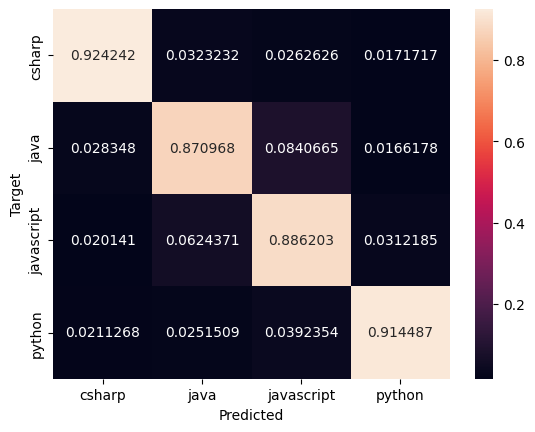

In [12]:
cm = confusion_matrix(datasets["test"]["label"], test_pred, normalize="true")
plot_confusion_matrix(cm)

### Best model

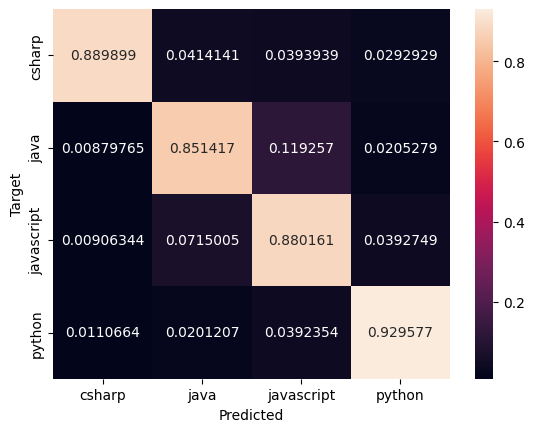

In [13]:
model_ckpt_best = pipeline(
    "text-classification",
    model="../stackoverflow-classifier-training-dir/checkpoint-1000",
    truncation=True,
    device=-1)

test_pred = model_ckpt_best(datasets["test"]["text"])
test_pred = [int(prd["label"][-1]) for prd in test_pred]

cm = confusion_matrix(datasets["test"]["label"], test_pred, normalize="true")
plot_confusion_matrix(cm)